<a href="https://colab.research.google.com/github/rahulsai1999/earthquake-pred/blob/master/gorkha_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import random

In [0]:
X=pd.read_csv("/content/drive/My Drive/Colab Data/Earthquake/X.csv")
Y=pd.read_csv("/content/drive/My Drive/Colab Data/Earthquake/Y.csv")

In [0]:
X=X.iloc[:100000,1:]
Y=Y.iloc[:100000,1]

In [0]:
X=pd.get_dummies(X,columns=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])

In [0]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

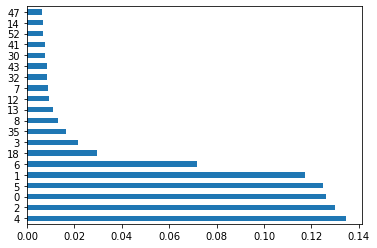

In [8]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,Y_train)

X_train=pd.DataFrame(X_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)

f=feat_importances.nlargest(30).index
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [0]:
f=pd.Series(f)
best=X_train[f]
X_train=best

X_test=pd.DataFrame(X_test)
best=X_test[f]
X_test=best

## Baseline Models

### Decision Tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
dc=DecisionTreeClassifier()

In [11]:
dc.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
Y_pred=dc.predict(X_test)
print(classification_report(Y_test,Y_pred))
print("Accuracy => %.3f" %(dc.score(X_test,Y_test)*100))

              precision    recall  f1-score   support

           1       0.45      0.48      0.46      1911
           2       0.70      0.69      0.69     11448
           3       0.59      0.60      0.59      6641

    accuracy                           0.64     20000
   macro avg       0.58      0.59      0.58     20000
weighted avg       0.64      0.64      0.64     20000

Accuracy => 63.710


### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegressionCV
lg=LogisticRegressionCV()

In [0]:
lg.fit(X_train,Y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
Y_pred=lg.predict(X_test)
print(classification_report(Y_test,Y_pred))
print("Accuracy => %.3f" %(lg.score(X_test,Y_test)*100))

              precision    recall  f1-score   support

           1       0.54      0.29      0.38      1911
           2       0.60      0.88      0.71     11448
           3       0.53      0.18      0.27      6641

    accuracy                           0.59     20000
   macro avg       0.56      0.45      0.45     20000
weighted avg       0.57      0.59      0.53     20000

Accuracy => 58.820


## Deep Learning Classifier

In [13]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.utils import np_utils,to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
sess=tf.Session()
K.set_session(sess)
hidl=8
num_ne=128
feature_dim=X_train.shape[1]
optim="Adamax"
activ="relu"
kern="normal"

In [0]:
def create_model(optimizer=optim,activation=activ,kernel_initializer=kern,neurons_num=num_ne,hidden_layers=hidl):
  model=Sequential()
  model.add(Dense(feature_dim,input_dim=feature_dim,kernel_initializer=kernel_initializer,activation=activation))
  for _ in range(0,hidden_layers-1):
    model.add(Dense(neurons_num,kernel_initializer=kernel_initializer,activation=activation))
    model.add(Dense(4,kernel_initializer='normal',activation='softmax'))
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=["accuracy"])
    return model

In [0]:
def print_best(grid_result):
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Tuning Batch Size and Epochs

In [0]:
model=KerasClassifier(build_fn=create_model,verbose=0)
batch_size=[20,40]
epochs=[10,50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=3)
grid_result = grid.fit(X_train, Y_train)

epochs=grid_result.best_params_['epochs']
batch=grid_result.best_params_['batch_size']

print_best(grid_result)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






Best: 0.661775 using {'batch_size': 20, 'epochs': 50}
0.648175 (0.005329) with: {'batch_size': 20, 'epochs': 10}
0.661775 (0.003222) with: {'batch_size': 20, 'epochs': 50}
0.639463 (0.006983) with: {'batch_size': 40, 'epochs': 10}
0.656075 (0.003948) with: {'batch_size': 40, 'epochs': 50}


### Tuning Optimizer

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

optim=grid_result.best_params_['optimizer']

print_best(grid_result)

Best: 0.659163 using {'optimizer': 'Adamax'}
0.576362 (0.034135) with: {'optimizer': 'SGD'}
0.632713 (0.002084) with: {'optimizer': 'Adagrad'}
0.655325 (0.000910) with: {'optimizer': 'Adam'}
0.659163 (0.001882) with: {'optimizer': 'Adamax'}
0.650000 (0.004458) with: {'optimizer': 'Nadam'}


### Tuning Activation Function

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
activation = ['softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

activ=grid_result.best_params_['activation']

print_best(grid_result)

Best: 0.660863 using {'activation': 'tanh'}
0.654100 (0.003974) with: {'activation': 'softplus'}
0.660275 (0.001119) with: {'activation': 'softsign'}
0.658838 (0.005332) with: {'activation': 'relu'}
0.660863 (0.001261) with: {'activation': 'tanh'}
0.639825 (0.008458) with: {'activation': 'sigmoid'}
0.655863 (0.003203) with: {'activation': 'hard_sigmoid'}
0.579588 (0.002868) with: {'activation': 'linear'}


### Tuning Kernel Initializer

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(kernel_initializer=kernel_initializer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

kern=grid_result.best_params_['kernel_initializer']

print_best(grid_result)

Best: 0.658688 using {'kernel_initializer': 'normal'}
0.657000 (0.001101) with: {'kernel_initializer': 'uniform'}
0.650350 (0.002274) with: {'kernel_initializer': 'lecun_uniform'}
0.658688 (0.001236) with: {'kernel_initializer': 'normal'}
0.566775 (0.002986) with: {'kernel_initializer': 'zero'}
0.654338 (0.002586) with: {'kernel_initializer': 'glorot_normal'}
0.649950 (0.001574) with: {'kernel_initializer': 'glorot_uniform'}
0.645000 (0.004980) with: {'kernel_initializer': 'he_normal'}
0.643763 (0.006206) with: {'kernel_initializer': 'he_uniform'}


### Tuning Number of Neurons

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
neurons_num = [32, 64, 128, 256]
param_grid = dict(neurons_num=neurons_num)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

num_ne=grid_result.best_params_['neurons_num']

print_best(grid_result)

Best: 0.660938 using {'neurons_num': 128}
0.657938 (0.002214) with: {'neurons_num': 32}
0.657575 (0.004129) with: {'neurons_num': 64}
0.660938 (0.002828) with: {'neurons_num': 128}
0.656687 (0.003365) with: {'neurons_num': 256}


### Tuning Number of Hidden Layers

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch, verbose=0)
hidden_layers = [2,4,8,10,12,14]
param_grid = dict(hidden_layers=hidden_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

hidl=grid_result.best_params_['hidden_layers']

print_best(grid_result)

Best: 0.659925 using {'hidden_layers': 12}
0.653362 (0.005286) with: {'hidden_layers': 2}
0.655637 (0.000375) with: {'hidden_layers': 4}
0.658525 (0.002320) with: {'hidden_layers': 8}
0.657825 (0.000195) with: {'hidden_layers': 10}
0.659925 (0.001904) with: {'hidden_layers': 12}
0.658363 (0.003940) with: {'hidden_layers': 14}


### Using the Best Model

In [17]:
# model=create_model(optim,activ,kern,num_ne,hidl)
model=create_model("Adamax","tanh","normal",128,12)

In [29]:
# model.fit(X_train,Y_train,epochs=epochs,batch_size=batch,verbose=0,validation_split=0.15)
model.fit(X_train,Y_train,epochs=50,batch_size=20,verbose=0,validation_split=0.15)

In [20]:
Y_pred=model.predict_classes(X_test)
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.62      0.34      0.44      1911
           2       0.68      0.80      0.74     11448
           3       0.64      0.54      0.59      6641

    accuracy                           0.67     20000
   macro avg       0.65      0.56      0.59     20000
weighted avg       0.66      0.67      0.66     20000



In [21]:
scores=model.evaluate(X_test,Y_test,verbose=2)
print("\nTest %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Test acc: 66.80%


In [0]:
X_validate=pd.read_csv("/content/drive/My Drive/Colab Data/Earthquake/X_test.csv")

X_id=X_validate.iloc[:,0]
X_actual=X_validate.iloc[:,1:]

In [0]:
X_actual=pd.get_dummies(X_actual,columns=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'])

In [0]:
X_actual=sc.fit_transform(X_actual)

In [0]:
X_actual=pd.DataFrame(X_actual)
best=X_actual[f]
X_actual=best

In [0]:
Y_pred=model.predict_classes(X_actual)

In [0]:
Y_final=pd.concat([X_id,pd.Series(Y_pred)],axis=1)

In [0]:
Y_final.to_csv('final.csv',header=True,index=False)